In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import re

warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

from sklearn.preprocessing import StandardScaler

In [19]:
# Görselleştirme ayarları
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True

# Pandas ayarları
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("="*70)
print("  YOUTUBE TREND TAHMİN SİSTEMİ - VERİ ANALİZİ".center(70))
print("="*70)
print(f"\n Tüm kütüphaneler yüklendi!")
print(f" Analiz Tarihi: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f" Sorumlu: Ömer")
print(f" Ekip: TrendHunters (Ömer, Muhamed, Emad)")
print("="*70)

              YOUTUBE TREND TAHMİN SİSTEMİ - VERİ ANALİZİ             

 Tüm kütüphaneler yüklendi!
 Analiz Tarihi: 2025-11-24 23:48:33
 Sorumlu: Ömer
 Ekip: TrendHunters (Ömer, Muhamed, Emad)


In [1]:
file_path = r'C:\Users\omer\Desktop\Youtube Videos Trend Project\US_Videos_Dataset.csv'

print("\n Veri dosyası yükleniyor...")
print(f" Dosya Yolu: {file_path}")

try:
    # Veriyi yükle - encoding sorunları için
    df_original = pd.read_csv(
        file_path, 
        encoding='utf-8',
        on_bad_lines='skip'  # Hatalı satırları atla
    )
    
    print(f"\n VERİ BAŞARIYLA YÜKLENDİ!")
    print(f" Toplam Satır: {df_original.shape[0]:,}")
    print(f" Toplam Sütun: {df_original.shape[1]}")
    
    # Kopyasını oluştur (orijinali koru)
    df = df_original.copy()
    
except FileNotFoundError:
    print(f"\n HATA: Dosya bulunamadı!")
    print(f"Kontrol edin: {file_path}")
    
except Exception as e:
    print(f"\n HATA: {e}")


 Veri dosyası yükleniyor...
 Dosya Yolu: C:\Users\omer\Desktop\Youtube Videos Trend Project\US_Videos_Dataset.csv

 HATA: name 'pd' is not defined


In [21]:
# Boyut bilgisi
print(f"\n VERİ BOYUTU:")
print(f"   • Toplam Satır: {df.shape[0]:,}")
print(f"   • Toplam Sütun: {df.shape[1]}")
print(f"   • Toplam Hücre: {df.shape[0] * df.shape[1]:,}")
print(f"   • Hafıza Kullanımı: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Sütun isimleri
print(f"\n SÜTUN LİSTESİ:")
for i, col in enumerate(df.columns, 1):
    dtype = str(df[col].dtype)
    unique = df[col].nunique()
    missing = df[col].isnull().sum()
    missing_pct = (missing / len(df) * 100)
    
    print(f"   {i:2d}. {col:25s} | Tip: {dtype:10s} | Unique: {unique:7,} | Eksik: {missing:6,} ({missing_pct:5.2f}%)")

# İlk 5 satır
print(f"\n İLK 5 SATIR:")
print(df.head())

# Son 5 satır
print(f"\n SON 5 SATIR:")
print(df.tail())


 VERİ BOYUTU:
   • Toplam Satır: 395,915
   • Toplam Sütun: 15
   • Toplam Hücre: 5,938,725
   • Hafıza Kullanımı: 748.66 MB

 SÜTUN LİSTESİ:
    1. video_id                  | Tip: object     | Unique: 189,881 | Eksik:      0 ( 0.00%)
    2. title                     | Tip: object     | Unique: 189,478 | Eksik:      0 ( 0.00%)
    3. publishedAt               | Tip: object     | Unique: 187,136 | Eksik:  5,851 ( 1.48%)
    4. channelId                 | Tip: object     | Unique:  66,901 | Eksik:      0 ( 0.00%)
    5. channelTitle              | Tip: object     | Unique:  67,140 | Eksik:      4 ( 0.00%)
    6. categoryId                | Tip: float64    | Unique:      16 | Eksik:     17 ( 0.00%)
    7. trending_date             | Tip: object     | Unique:     832 | Eksik: 218,383 (55.16%)
    8. tags                      | Tip: object     | Unique: 100,682 | Eksik: 123,911 (31.30%)
    9. view_count                | Tip: float64    | Unique: 342,368 | Eksik:     17 ( 0.00%)
   10. li

In [22]:
# Her sütun için detaylı analiz
quality_analysis = []

for col in df.columns:
    analysis = {
        'Sütun': col,
        'Veri Tipi': str(df[col].dtype),
        'Toplam': len(df),
        'Dolu': df[col].notna().sum(),
        'Eksik': df[col].isnull().sum(),
        'Eksik %': round(df[col].isnull().sum() / len(df) * 100, 2),
        'Unique': df[col].nunique(),
        'En Sık': df[col].mode()[0] if len(df[col].mode()) > 0 else None,
    }
    
    # Sayısal değişkenler için istatistikler
    if pd.api.types.is_numeric_dtype(df[col]):
        analysis['Min'] = df[col].min()
        analysis['Max'] = df[col].max()
        analysis['Ortalama'] = round(df[col].mean(), 2)
        analysis['Medyan'] = df[col].median()
    else:
        analysis['Min'] = None
        analysis['Max'] = None
        analysis['Ortalama'] = None
        analysis['Medyan'] = None
    
    quality_analysis.append(analysis)

quality_df = pd.DataFrame(quality_analysis)
print("\n📊 VERİ KALİTESİ RAPORU:")
print(quality_df.to_string(index=False))

# Özet
print(f"\n📈 ÖZET:")
total_cells = df.shape[0] * df.shape[1]
total_missing = df.isnull().sum().sum()
print(f"   • Toplam Hücre: {total_cells:,}")
print(f"   • Eksik Hücre: {total_missing:,}")
print(f"   • Eksik Oran: {(total_missing / total_cells * 100):.2f}%")
print(f"   • Dolu Oran: {((total_cells - total_missing) / total_cells * 100):.2f}%")

# En çok eksik olan sütunlar
if total_missing > 0:
    print(f"\n⚠️ EN ÇOK EKSİK DEĞER İÇEREN SÜTUNLAR:")
    missing_cols = df.isnull().sum().sort_values(ascending=False)
    missing_cols = missing_cols[missing_cols > 0]
    for col, count in missing_cols.head(10).items():
        pct = (count / len(df) * 100)
        print(f"   • {col:25s}: {count:7,} ({pct:5.2f}%)")
else:
    print(f"\n✅ HİÇ EKSİK DEĞER YOK!")


📊 VERİ KALİTESİ RAPORU:
            Sütun Veri Tipi  Toplam   Dolu  Eksik  Eksik %  Unique                                                                                                                                                                                                                                                                                                                                                                                                                                                                               En Sık  Min           Max   Ortalama    Medyan
         video_id    object  395915 395915      0     0.00  189881                                                                                                                                                                                                                                                                                                                                             


 Sayısal Değişkenler (6 adet):
   1. categoryId
   2. view_count
   3. likes
   4. comment_count
   5. comments_disabled
   6. is_trending

 TEMEL İSTATİSTİKLER:
                      count       mean         std  min       25%       50%  \
categoryId        395898.00      20.43        6.52 1.00     19.00     22.00   
view_count        395898.00 7615071.31 49758216.91 0.00 267423.25 787030.00   
likes             395898.00  159828.95   679233.02 0.00   5408.00  24142.50   
comment_count     395898.00    4506.25    44907.74 0.00    125.00    858.00   
comments_disabled 395915.00       0.02        0.14 0.00      0.00      0.00   
is_trending       395915.00       0.45        0.50 0.00      0.00      0.00   

                         75%           max            variance  skewness  \
categoryId             24.00         30.00               42.46     -1.50   
view_count        2737117.50 4168918788.00 2475880150550172.50     32.30   
likes               82678.25   43378323.00     46135749

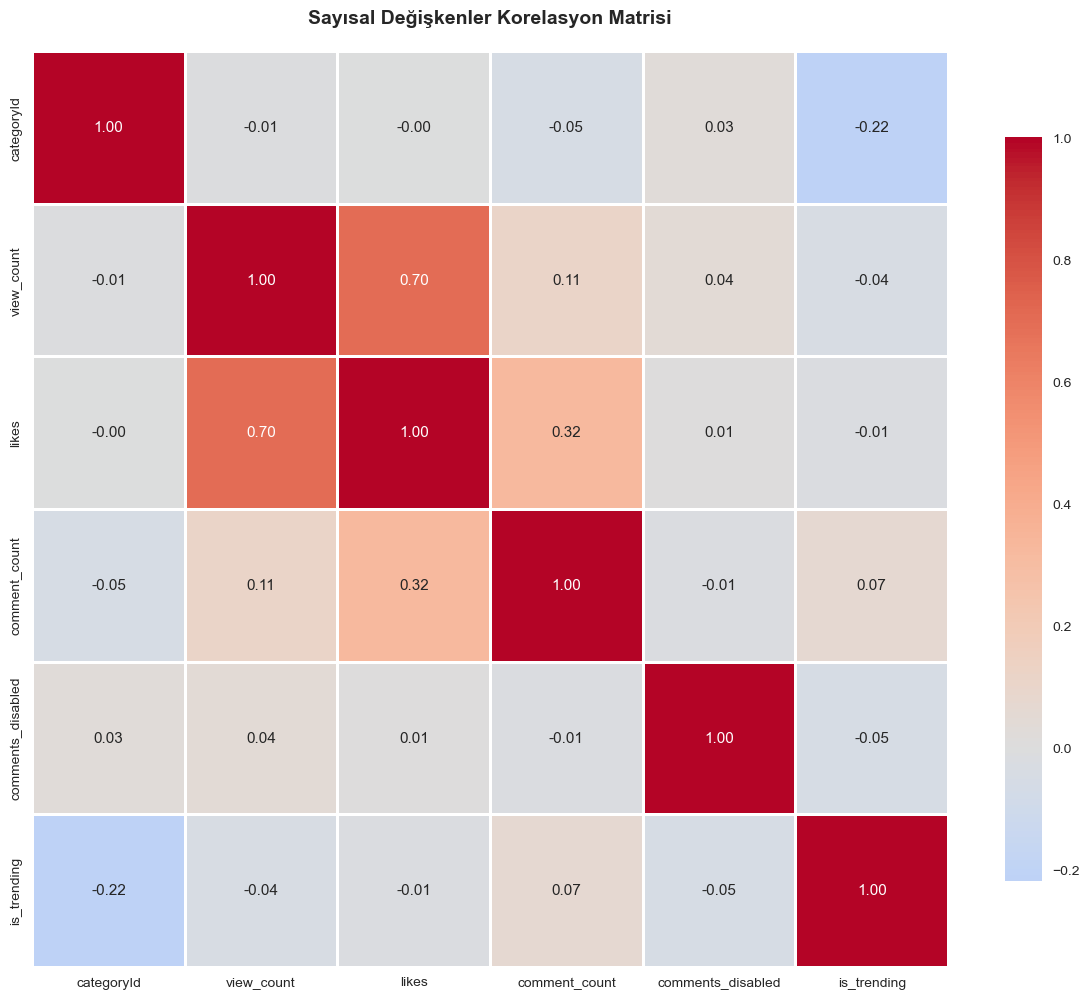

In [23]:
# Sayısal sütunları bul
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n Sayısal Değişkenler ({len(numeric_cols)} adet):")
for i, col in enumerate(numeric_cols, 1):
    print(f"   {i}. {col}")

if len(numeric_cols) > 0:
    # Temel istatistikler
    print(f"\n TEMEL İSTATİSTİKLER:")
    stats = df[numeric_cols].describe().T
    stats['variance'] = df[numeric_cols].var()
    stats['skewness'] = df[numeric_cols].skew()
    stats['kurtosis'] = df[numeric_cols].kurtosis()
    print(stats)
    
    # Korelasyon matrisi
    if len(numeric_cols) > 1:
        print(f"\n KORELASYON MATRİSİ:")
        corr_matrix = df[numeric_cols].corr()
        print(corr_matrix)
        
        # Korelasyon ısı haritası
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            corr_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8}
        )
        plt.title('Sayısal Değişkenler Korelasyon Matrisi', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        # Klasör yoksa oluştur
        import os
        os.makedirs('figures', exist_ok=True)
        
        plt.savefig('figures/01_correlation_matrix.png', dpi=300, bbox_inches='tight')
        print("\n Grafik kaydedildi: figures/01_correlation_matrix.png")
        plt.show()


 Sayısal değişkenlerin dağılımları görselleştiriliyor...
✅ Grafik kaydedildi: figures/02_numeric_distributions.png


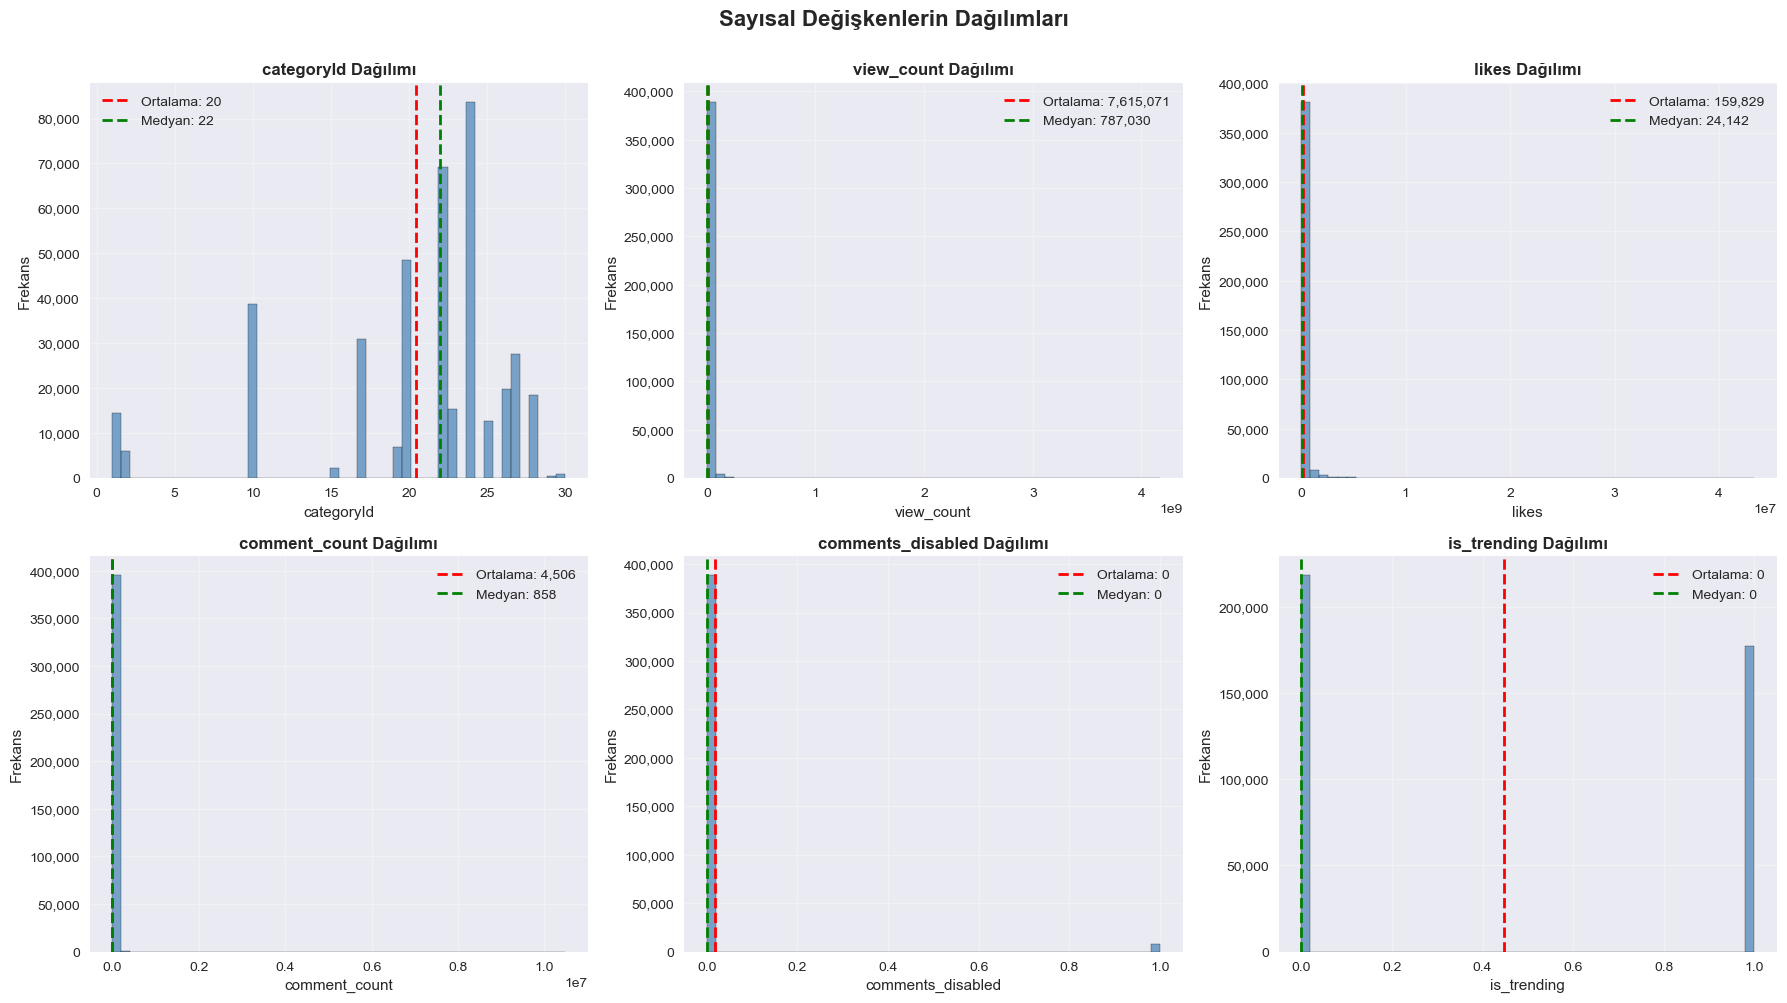

In [24]:
if len(numeric_cols) > 0:
    print("\n Sayısal değişkenlerin dağılımları görselleştiriliyor...")
    
    # Her sütun için histogram
    n_cols = min(len(numeric_cols), 6)  # Maksimum 6 grafik
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 5))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for idx, col in enumerate(numeric_cols[:6]):
        ax = axes[idx]
        
        # Histogram
        data = df[col].dropna()
        ax.hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        
        # İstatistikler ekle
        mean_val = data.mean()
        median_val = data.median()
        
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Ortalama: {mean_val:,.0f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Medyan: {median_val:,.0f}')
        
        ax.set_title(f'{col} Dağılımı', fontsize=12, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Frekans')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Y ekseni formatı
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    
    # Boş grafikleri gizle
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Sayısal Değişkenlerin Dağılımları', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('figures/02_numeric_distributions.png', dpi=300, bbox_inches='tight')
    print("✅ Grafik kaydedildi: figures/02_numeric_distributions.png")
    plt.show()


 Outlier analizi yapılıyor...
 Grafik kaydedildi: figures/03_boxplots_outliers.png


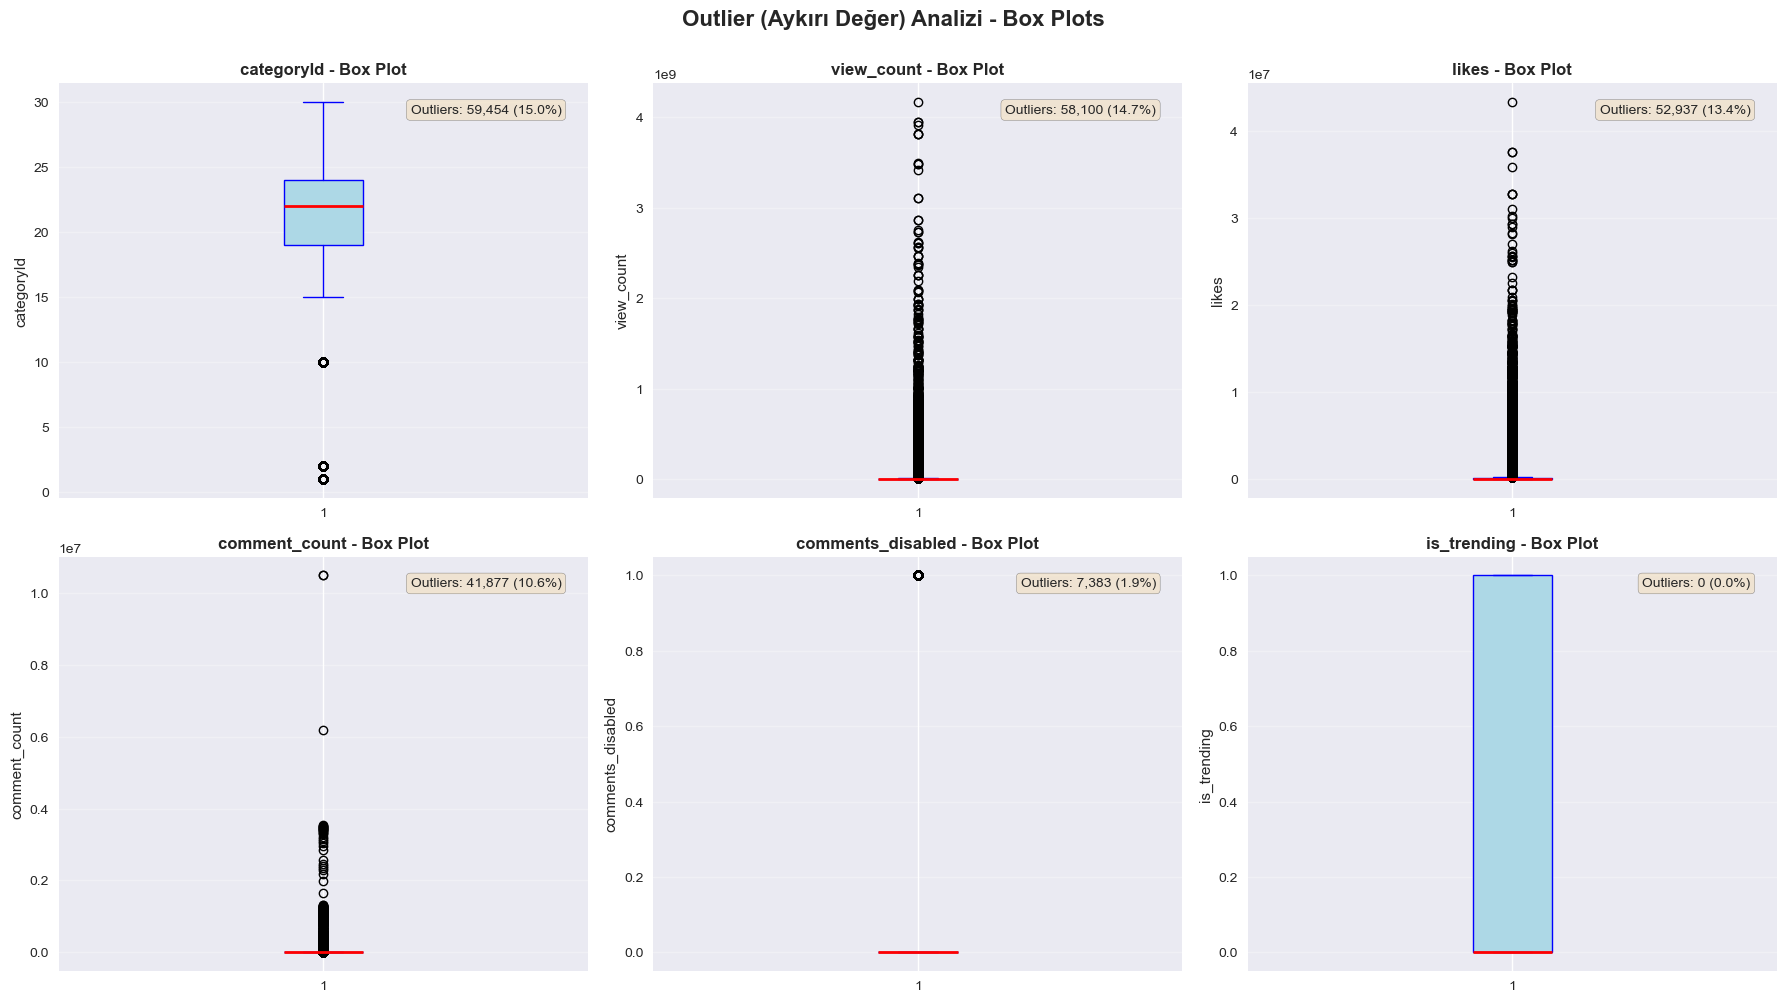

In [25]:
if len(numeric_cols) > 0:
    print("\n Outlier analizi yapılıyor...")
    
    n_cols = min(len(numeric_cols), 6)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 5))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for idx, col in enumerate(numeric_cols[:6]):
        ax = axes[idx]
        
        # Box plot
        data = df[col].dropna()
        bp = ax.boxplot(data, vert=True, patch_artist=True, 
                        boxprops=dict(facecolor='lightblue', color='blue'),
                        medianprops=dict(color='red', linewidth=2),
                        whiskerprops=dict(color='blue'),
                        capprops=dict(color='blue'))
        
        ax.set_title(f'{col} - Box Plot', fontsize=12, fontweight='bold')
        ax.set_ylabel(col)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Outlier sayısı hesapla
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        outlier_count = len(outliers)
        outlier_pct = (outlier_count / len(data) * 100)
        
        # Bilgi ekle
        ax.text(0.95, 0.95, f'Outliers: {outlier_count:,} ({outlier_pct:.1f}%)',
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Boş grafikleri gizle
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Outlier (Aykırı Değer) Analizi - Box Plots', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('figures/03_boxplots_outliers.png', dpi=300, bbox_inches='tight')
    print(" Grafik kaydedildi: figures/03_boxplots_outliers.png")
    plt.show()

In [26]:
# Kategorik sütunları bul
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\n Kategorik Değişkenler ({len(categorical_cols)} adet):")
for i, col in enumerate(categorical_cols, 1):
    unique_count = df[col].nunique()
    print(f"   {i}. {col:25s} - Unique: {unique_count:7,}")

# Her kategorik değişken için value counts
if len(categorical_cols) > 0:
    for col in categorical_cols[:5]:  # İlk 5 kategorik değişken
        print(f"\n {col} - En Sık 10 Değer:")
        value_counts = df[col].value_counts().head(10)
        
        for idx, (value, count) in enumerate(value_counts.items(), 1):
            pct = (count / len(df) * 100)
            # Uzun değerleri kısalt
            value_str = str(value)[:50] + '...' if len(str(value)) > 50 else str(value)
            print(f"   {idx:2d}. {value_str:50s}: {count:7,} ({pct:5.2f}%)")


 Kategorik Değişkenler (9 adet):
   1. video_id                  - Unique: 189,881
   2. title                     - Unique: 189,478
   3. publishedAt               - Unique: 187,136
   4. channelId                 - Unique:  66,901
   5. channelTitle              - Unique:  67,140
   6. trending_date             - Unique:     832
   7. tags                      - Unique: 100,682
   8. thumbnail_link            - Unique: 189,927
   9. description               - Unique: 139,989

 video_id - En Sık 10 Değer:
    1. QdBZY2fkU-0                                       :      37 ( 0.01%)
    2. 3ryID_SwU5E                                       :      37 ( 0.01%)
    3. tWYsfOSY9vY                                       :      37 ( 0.01%)
    4. J_z-W4UVHkw                                       :      37 ( 0.01%)
    5. tnTPaLOaHz8                                       :      37 ( 0.01%)
    6. 9RhWXPcKBI8                                       :      36 ( 0.01%)
    7. 7hYbrdC_-s8            


 Kategorik değişkenler görselleştiriliyor...
 Grafik kaydedildi: figures/04_categorical_distributions.png


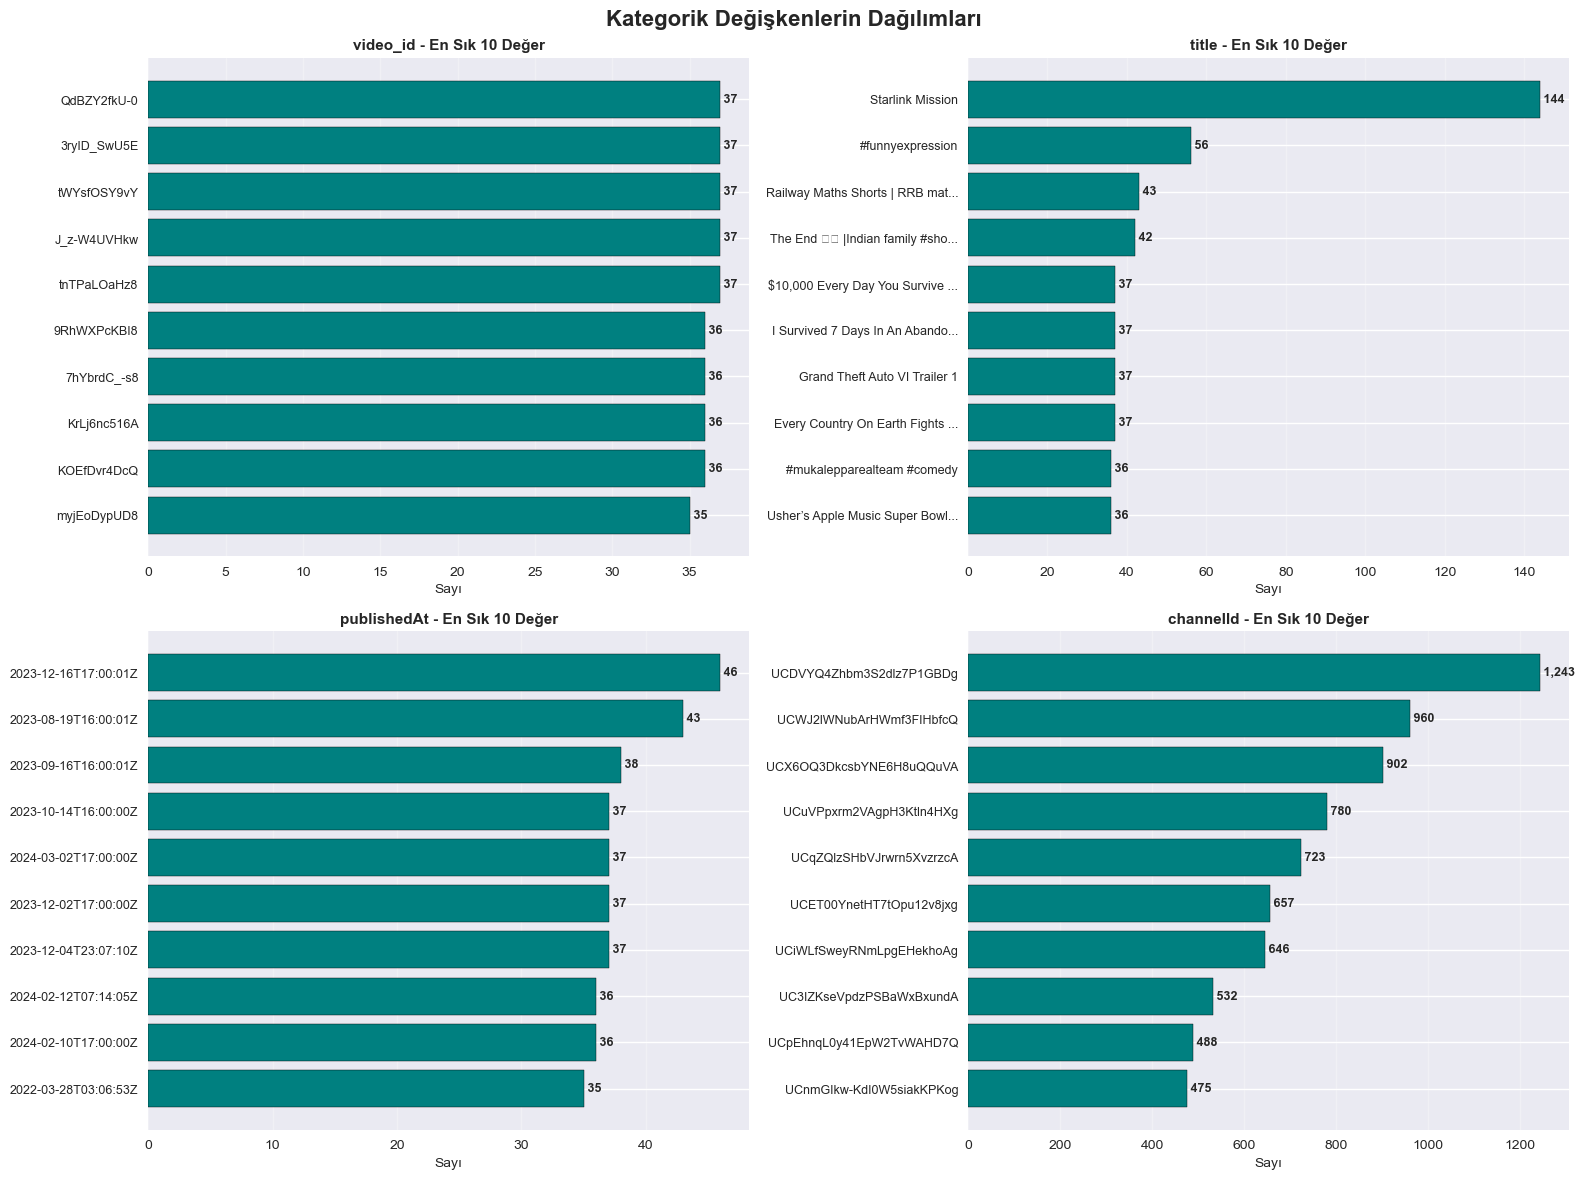

In [27]:
if len(categorical_cols) > 0:
    print("\n Kategorik değişkenler görselleştiriliyor...")
    
    # İlk 4 kategorik değişken için bar plot
    n_plots = min(len(categorical_cols), 4)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, col in enumerate(categorical_cols[:4]):
        ax = axes[idx]
        
        # Top 10 değer
        value_counts = df[col].value_counts().head(10)
        
        # Bar plot
        bars = ax.barh(range(len(value_counts)), value_counts.values, color='teal', edgecolor='black')
        ax.set_yticks(range(len(value_counts)))
        
        # Etiketleri kısalt
        labels = [str(x)[:30] + '...' if len(str(x)) > 30 else str(x) for x in value_counts.index]
        ax.set_yticklabels(labels, fontsize=9)
        
        ax.set_xlabel('Sayı', fontsize=10)
        ax.set_title(f'{col} - En Sık 10 Değer', fontsize=11, fontweight='bold')
        ax.invert_yaxis()
        
        # Değerleri bar üzerine yaz
        for i, (bar, value) in enumerate(zip(bars, value_counts.values)):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, 
            f' {value:,}', 
            ha='left', va='center', fontsize=9, fontweight='bold')
        
        ax.grid(True, alpha=0.3, axis='x')
    
    plt.suptitle('Kategorik Değişkenlerin Dağılımları', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('figures/04_categorical_distributions.png', dpi=300, bbox_inches='tight')
    print(" Grafik kaydedildi: figures/04_categorical_distributions.png")
    plt.show()

In [28]:
print("\n" + "="*70)
print("  VERİ KAYDEDILIYOR ".center(70, "="))
print("="*70)

# Klasör oluştur
import os
os.makedirs('processed_data', exist_ok=True)

# Veriyi kaydet
output_file = 'processed_data/youtube_data_initial.csv'
df.to_csv(output_file, index=False, encoding='utf-8')

print(f"\n VERİ KAYDEDİLDİ!")
print(f" Dosya: {output_file}")
print(f" Boyut: {df.shape[0]:,} satır × {df.shape[1]} sütun")

# Dosya boyutu
file_size = os.path.getsize(output_file) / (1024 * 1024)
print(f" Dosya Boyutu: {file_size:.2f} MB")


=========================  VERİ KAYDEDILIYOR =========================

 VERİ KAYDEDİLDİ!
 Dosya: processed_data/youtube_data_initial.csv
 Boyut: 395,915 satır × 15 sütun
 Dosya Boyutu: 351.26 MB


In [29]:

print("  ÖZET RAPOR ".center(70, "="))

print(f"\n TAMAMLANAN İŞLEMLER:")
print(f"   1. ✓ Veri başarıyla yüklendi ({df.shape[0]:,} satır)")
print(f"   2. ✓ Veri kalitesi analiz edildi")
print(f"   3. ✓ Sayısal değişkenler incelendi ({len(numeric_cols)} adet)")
print(f"   4. ✓ Kategorik değişkenler incelendi ({len(categorical_cols)} adet)")
print(f"   5. ✓ Görselleştirmeler oluşturuldu")
print(f"   6. ✓ İşlenmiş veri kaydedildi")

print(f"\n VERİ İSTATİSTİKLERİ:")
print(f"   • Toplam Satır: {df.shape[0]:,}")
print(f"   • Toplam Sütun: {df.shape[1]}")
print(f"   • Sayısal Sütun: {len(numeric_cols)}")
print(f"   • Kategorik Sütun: {len(categorical_cols)}")
print(f"   • Eksik Değer: {df.isnull().sum().sum():,}")
print(f"   • Dolu Oran: {((1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100):.2f}%")

print(f"\n OLUŞTURULAN DOSYALAR:")
print(f"   • processed_data/youtube_data_initial.csv")
print(f"   • figures/01_correlation_matrix.png")
print(f"   • figures/02_numeric_distributions.png")
print(f"   • figures/03_boxplots_outliers.png")
print(f"   • figures/04_categorical_distributions.png")

print(f"\n SONRAKİ ADIMLAR (Notebook 2):")
print(f"   1. Veri temizleme (eksik değerler, outliers)")
print(f"   2. Feature engineering (yeni özellikler)")
print(f"   3. Tarih özellikleri çıkarma")
print(f"   4. Text analizi (title, tags, description)")
print(f"   5. Kategori encoding")

print("\n" + "="*70)
print("  NOTEBOOK 1 TAMAMLANDI! ".center(70, "="))
print("="*70)
print(f"\n👤 Hazırlayan: Ömer")
print(f"👥 Ekip: TrendHunters (Ömer, Muhamed, Emad)")
print(f"📅 Tarih: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\n🚀 İyi çalışmalar!")
print("="*70)

============================  ÖZET RAPOR =============================

 TAMAMLANAN İŞLEMLER:
   1. ✓ Veri başarıyla yüklendi (395,915 satır)
   2. ✓ Veri kalitesi analiz edildi
   3. ✓ Sayısal değişkenler incelendi (6 adet)
   4. ✓ Kategorik değişkenler incelendi (9 adet)
   5. ✓ Görselleştirmeler oluşturuldu
   6. ✓ İşlenmiş veri kaydedildi

 VERİ İSTATİSTİKLERİ:
   • Toplam Satır: 395,915
   • Toplam Sütun: 15
   • Sayısal Sütun: 6
   • Kategorik Sütun: 9
   • Eksik Değer: 409,727
   • Dolu Oran: 93.10%

 OLUŞTURULAN DOSYALAR:
   • processed_data/youtube_data_initial.csv
   • figures/01_correlation_matrix.png
   • figures/02_numeric_distributions.png
   • figures/03_boxplots_outliers.png
   • figures/04_categorical_distributions.png

 SONRAKİ ADIMLAR (Notebook 2):
   1. Veri temizleme (eksik değerler, outliers)
   2. Feature engineering (yeni özellikler)
   3. Tarih özellikleri çıkarma
   4. Text analizi (title, tags, description)
   5. Kategori encoding

======================  NOT

In [30]:
df_clean = df.copy()

print("  TARİH ÖZELLİKLERİ ÇIKARMA ".center(70, "="))
print("="*70)

# publishedAt ve trending_date'i datetime'a çevir
date_cols = ['publishedAt', 'trending_date']

for col in date_cols:
    if col in df_clean.columns:
        try:
            # Farklı formatları dene
            if df_clean[col].dtype == 'object':
                # Önce standart ISO format
                try:
                    df_clean[col] = pd.to_datetime(df_clean[col])
                    print(f"✓ '{col}' datetime'a çevrildi")
                except:
                    # YY.DD.MM formatı
                    try:
                        df_clean[col] = pd.to_datetime(df_clean[col], format='%y.%d.%m')
                        print(f"✓ '{col}' datetime'a çevrildi (YY.DD.MM)")
                    except:
                        print(f" '{col}' çevrilemedi")
        except Exception as e:
            print(f" '{col}' hatası: {e}")

# Tarih özellikleri çıkar
if 'publishedAt' in df_clean.columns and pd.api.types.is_datetime64_any_dtype(df_clean['publishedAt']):
    print(f"\n🔧 Tarih özellikleri oluşturuluyor...")
    
    # Publish özellikleri
    df_clean['publish_year'] = df_clean['publishedAt'].dt.year
    df_clean['publish_month'] = df_clean['publishedAt'].dt.month
    df_clean['publish_day'] = df_clean['publishedAt'].dt.day
    df_clean['publish_hour'] = df_clean['publishedAt'].dt.hour
    df_clean['publish_dayofweek'] = df_clean['publishedAt'].dt.dayofweek  # 0=Monday
    df_clean['publish_quarter'] = df_clean['publishedAt'].dt.quarter
    df_clean['publish_weekofyear'] = df_clean['publishedAt'].dt.isocalendar().week
    
    # Hafta sonu mu?
    df_clean['is_weekend'] = df_clean['publish_dayofweek'].isin([5, 6]).astype(int)
    
    # Zaman dilimi (sabah, öğle, akşam, gece)
    def get_time_period(hour):
        if 6 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 18:
            return 'Afternoon'
        elif 18 <= hour < 24:
            return 'Evening'
        else:
            return 'Night'
    
    df_clean['time_period'] = df_clean['publish_hour'].apply(get_time_period)
    
    print(f"   ✓ publish_year")
    print(f"   ✓ publish_month")
    print(f"   ✓ publish_day")
    print(f"   ✓ publish_hour")
    print(f"   ✓ publish_dayofweek")
    print(f"   ✓ publish_quarter")
    print(f"   ✓ publish_weekofyear")
    print(f"   ✓ is_weekend")
    print(f"   ✓ time_period")
    
    # Days to trend (publish'dan trend'e kadar geçen gün)
    if 'trending_date' in df_clean.columns and pd.api.types.is_datetime64_any_dtype(df_clean['trending_date']):
        df_clean['days_to_trend'] = (df_clean['trending_date'] - df_clean['publishedAt']).dt.days
        
        # Negatif değerleri temizle
        if df_clean['days_to_trend'].min() < 0:
            negative_count = (df_clean['days_to_trend'] < 0).sum()
            print(f"\n {negative_count:,} negatif 'days_to_trend' tespit edildi, temizleniyor...")
            df_clean = df_clean[df_clean['days_to_trend'] >= 0].copy()
            df_clean.reset_index(drop=True, inplace=True)
        
        print(f"   ✓ days_to_trend")
        print(f"      Min: {df_clean['days_to_trend'].min()} gün")
        print(f"      Max: {df_clean['days_to_trend'].max()} gün")
        print(f"      Ortalama: {df_clean['days_to_trend'].mean():.1f} gün")

print(f"\n Tarih özellikleri oluşturuldu!")
print(f" Yeni boyut: {df_clean.shape[0]:,} satır × {df_clean.shape[1]} sütun")

=====================  TARİH ÖZELLİKLERİ ÇIKARMA =====================
✓ 'publishedAt' datetime'a çevrildi
 'trending_date' çevrilemedi

🔧 Tarih özellikleri oluşturuluyor...
   ✓ publish_year
   ✓ publish_month
   ✓ publish_day
   ✓ publish_hour
   ✓ publish_dayofweek
   ✓ publish_quarter
   ✓ publish_weekofyear
   ✓ is_weekend
   ✓ time_period

 Tarih özellikleri oluşturuldu!
 Yeni boyut: 395,915 satır × 24 sütun


In [31]:
# TEXT FEATURES - BAŞLIK (TITLE) ANALİZİ
if 'title' in df_clean.columns:
    print(f"\n🔧 Başlık özellikleri oluşturuluyor...")
    
    # 1. Başlık uzunluğu
    df_clean['title_length'] = df_clean['title'].str.len()
    print(f"   ✓ title_length (karakter sayısı)")
    
    # 2. Kelime sayısı
    df_clean['title_word_count'] = df_clean['title'].str.split().str.len()
    print(f"   ✓ title_word_count (kelime sayısı)")
    
    # 3. Büyük harf var mı? (CAPS)
    df_clean['title_has_caps'] = df_clean['title'].str.isupper().astype(int)
    print(f"   ✓ title_has_caps (tümü büyük harf)")
    
    # 4. Büyük harf oranı
    def caps_ratio(text):
        if len(text) == 0:
            return 0
        return sum(1 for c in text if c.isupper()) / len(text)
    
    df_clean['title_caps_ratio'] = df_clean['title'].apply(caps_ratio)
    print(f"   ✓ title_caps_ratio (büyük harf oranı)")
    
    # 5. Soru işareti var mı?
    df_clean['title_has_question'] = df_clean['title'].str.contains('\?', na=False).astype(int)
    print(f"   ✓ title_has_question")
    
    # 6. Ünlem işareti var mı?
    df_clean['title_has_exclamation'] = df_clean['title'].str.contains('!', na=False).astype(int)
    print(f"   ✓ title_has_exclamation")
    
    # 7. Rakam var mı?
    df_clean['title_has_numbers'] = df_clean['title'].str.contains('\d', na=False).astype(int)
    print(f"   ✓ title_has_numbers")
    
    # 8. Özel karakterler
    df_clean['title_special_char_count'] = df_clean['title'].str.count('[^a-zA-Z0-9\s]')
    print(f"   ✓ title_special_char_count")
    
    # 9. Clickbait kelimeler (SHOCKING, AMAZING, etc.)
    clickbait_words = ['SHOCKING', 'AMAZING', 'INCREDIBLE', 'UNBELIEVABLE', 'MUST WATCH', 
                'YOU WON\'T BELIEVE', 'VIRAL', 'BREAKING', 'EXCLUSIVE']
    
    def has_clickbait(text):
        text_upper = text.upper()
        return int(any(word in text_upper for word in clickbait_words))
    
    df_clean['title_has_clickbait'] = df_clean['title'].apply(has_clickbait)
    print(f"   ✓ title_has_clickbait")
    
    # 10. Emoji var mı? (basit kontrol)
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            "]+", flags=re.UNICODE)
    
    df_clean['title_has_emoji'] = df_clean['title'].apply(
        lambda x: 1 if emoji_pattern.search(str(x)) else 0
    )
    print(f"   ✓ title_has_emoji")
    
    # İstatistikler
    print(f"\n📊 Başlık İstatistikleri:")
    print(f"   • Ortalama uzunluk: {df_clean['title_length'].mean():.1f} karakter")
    print(f"   • Ortalama kelime: {df_clean['title_word_count'].mean():.1f} kelime")
    print(f"   • Soru işaretli: {df_clean['title_has_question'].sum():,} ({df_clean['title_has_question'].mean()*100:.1f}%)")
    print(f"   • Ünlem işaretli: {df_clean['title_has_exclamation'].sum():,} ({df_clean['title_has_exclamation'].mean()*100:.1f}%)")
    print(f"   • Clickbait içeren: {df_clean['title_has_clickbait'].sum():,} ({df_clean['title_has_clickbait'].mean()*100:.1f}%)")

print(f"\n✅ Başlık özellikleri oluşturuldu!")


🔧 Başlık özellikleri oluşturuluyor...
   ✓ title_length (karakter sayısı)
   ✓ title_word_count (kelime sayısı)
   ✓ title_has_caps (tümü büyük harf)
   ✓ title_caps_ratio (büyük harf oranı)
   ✓ title_has_question
   ✓ title_has_exclamation
   ✓ title_has_numbers
   ✓ title_special_char_count
   ✓ title_has_clickbait
   ✓ title_has_emoji

📊 Başlık İstatistikleri:
   • Ortalama uzunluk: 58.6 karakter
   • Ortalama kelime: 9.6 kelime
   • Soru işaretli: 24,392 (6.2%)
   • Ünlem işaretli: 55,984 (14.1%)
   • Clickbait içeren: 16,189 (4.1%)

✅ Başlık özellikleri oluşturuldu!


In [32]:
print("  TAGS ANALİZİ ".center(70, "="))

if 'tags' in df_clean.columns:
    print(f"\n🔧 Tags özellikleri oluşturuluyor...")
    
    # 1. Tag sayısı (| ile ayrılmış)
    df_clean['tags_count'] = df_clean['tags'].apply(
        lambda x: len(str(x).split('|')) if str(x) != '' else 0
    )
    print(f"   ✓ tags_count")
    
    # 2. Tags toplam karakter sayısı
    df_clean['tags_length'] = df_clean['tags'].str.len()
    print(f"   ✓ tags_length")
    
    # 3. Ortalama tag uzunluğu
    def avg_tag_length(tags):
        if str(tags) == '' or str(tags) == 'nan':
            return 0
        tag_list = str(tags).split('|')
        if len(tag_list) == 0:
            return 0
        return sum(len(tag) for tag in tag_list) / len(tag_list)
    
    df_clean['tags_avg_length'] = df_clean['tags'].apply(avg_tag_length)
    print(f"   ✓ tags_avg_length")
    
    # İstatistikler
    print(f"\n Tags İstatistikleri:")
    print(f"   • Ortalama tag sayısı: {df_clean['tags_count'].mean():.1f}")
    print(f"   • Max tag sayısı: {df_clean['tags_count'].max()}")
    print(f"   • Tag'siz video: {(df_clean['tags_count'] == 0).sum():,} ({(df_clean['tags_count'] == 0).mean()*100:.1f}%)")

print(f"\n Tags özellikleri oluşturuldu!")

===========================  TAGS ANALİZİ ============================

🔧 Tags özellikleri oluşturuluyor...
   ✓ tags_count
   ✓ tags_length
   ✓ tags_avg_length

 Tags İstatistikleri:
   • Ortalama tag sayısı: 7.2
   • Max tag sayısı: 78
   • Tag'siz video: 0 (0.0%)

 Tags özellikleri oluşturuldu!


In [33]:
print("  DESCRIPTION ANALİZİ ".center(70, "="))

if 'description' in df_clean.columns:
    print(f"\n Description özellikleri oluşturuluyor...")
    
    # 1. Açıklama uzunluğu
    df_clean['description_length'] = df_clean['description'].str.len()
    print(f"   ✓ description_length")
    
    # 2. Kelime sayısı
    df_clean['description_word_count'] = df_clean['description'].str.split().str.len()
    print(f"   ✓ description_word_count")
    
    # 3. Link var mı?
    df_clean['description_has_link'] = df_clean['description'].str.contains(
        'http', case=False, na=False
    ).astype(int)
    print(f"   ✓ description_has_link")
    
    # 4. Link sayısı
    df_clean['description_link_count'] = df_clean['description'].str.count('http')
    print(f"   ✓ description_link_count")
    
    # 5. Email var mı?
    df_clean['description_has_email'] = df_clean['description'].str.contains(
        r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 
        regex=True, na=False
    ).astype(int)
    print(f"   ✓ description_has_email")
    
    # 6. Hashtag var mı?
    df_clean['description_has_hashtag'] = df_clean['description'].str.contains(
        '#', na=False
    ).astype(int)
    print(f"   ✓ description_has_hashtag")
    
    # 7. Hashtag sayısı
    df_clean['description_hashtag_count'] = df_clean['description'].str.count('#')
    print(f"   ✓ description_hashtag_count")
    
    # İstatistikler
    print(f"\n Description İstatistikleri:")
    print(f"   • Ortalama uzunluk: {df_clean['description_length'].mean():.0f} karakter")
    print(f"   • Link içeren: {df_clean['description_has_link'].sum():,} ({df_clean['description_has_link'].mean()*100:.1f}%)")
    print(f"   • Hashtag içeren: {df_clean['description_has_hashtag'].sum():,} ({df_clean['description_has_hashtag'].mean()*100:.1f}%)")

print(f"\n Description özellikleri oluşturuldu!")

========================  DESCRIPTION ANALİZİ ========================

 Description özellikleri oluşturuluyor...
   ✓ description_length
   ✓ description_word_count
   ✓ description_has_link
   ✓ description_link_count
   ✓ description_has_email
   ✓ description_has_hashtag
   ✓ description_hashtag_count

 Description İstatistikleri:
   • Ortalama uzunluk: 587 karakter
   • Link içeren: 182,645 (46.1%)
   • Hashtag içeren: 130,127 (32.9%)

 Description özellikleri oluşturuldu!


In [34]:
# ENGAGEMENT (ETKİLEŞİM) ÖZELLİKLERİ
print(" 📊 ENGAGEMENT ÖZELLİKLERİ ".center(70, "="))

print(f"\n🔧 Engagement özellikleri oluşturuluyor...")

# 1. Like rate (beğeni oranı)
df_clean['like_rate'] = df_clean['likes'] / (df_clean['view_count'] + 1)
print(f"   ✓ like_rate")

# 2. Comment rate (yorum oranı)
df_clean['comment_rate'] = df_clean['comment_count'] / (df_clean['view_count'] + 1)
print(f"   ✓ comment_rate")

# 3. Total engagement rate
df_clean['engagement_rate'] = (df_clean['likes'] + df_clean['comment_count']) / (df_clean['view_count'] + 1)
print(f"   ✓ engagement_rate")

# 4. Views per day (günlük ortalama izlenme)
if 'days_to_trend' in df_clean.columns:
    df_clean['views_per_day'] = df_clean['view_count'] / (df_clean['days_to_trend'] + 1)
    print(f"   ✓ views_per_day")

# 5. Likes per day
if 'days_to_trend' in df_clean.columns:
    df_clean['likes_per_day'] = df_clean['likes'] / (df_clean['days_to_trend'] + 1)
    print(f"   ✓ likes_per_day")

# 6. Comments per day
if 'days_to_trend' in df_clean.columns:
    df_clean['comments_per_day'] = df_clean['comment_count'] / (df_clean['days_to_trend'] + 1)
    print(f"   ✓ comments_per_day")

# 7. View velocity (hız göstergesi)
if 'days_to_trend' in df_clean.columns:
    df_clean['view_velocity'] = np.log1p(df_clean['views_per_day'])
    print(f"   ✓ view_velocity (log transform)")

# 8. Comments disabled indicator (eğer varsa)
if 'comments_disabled' in df_clean.columns:
    # Boolean to int
    if df_clean['comments_disabled'].dtype == 'bool':
        df_clean['comments_disabled'] = df_clean['comments_disabled'].astype(int)
    print(f"   ✓ comments_disabled (converted to int)")

# İstatistikler
print(f"\n📊 Engagement İstatistikleri:")
print(f"   • Ortalama like_rate: {df_clean['like_rate'].mean():.4f}")
print(f"   • Ortalama comment_rate: {df_clean['comment_rate'].mean():.4f}")
print(f"   • Ortalama engagement_rate: {df_clean['engagement_rate'].mean():.4f}")
if 'views_per_day' in df_clean.columns:
    print(f"   • Ortalama views_per_day: {df_clean['views_per_day'].mean():.0f}")

print(f"\n✅ Engagement özellikleri oluşturuldu!")

====================== 📊 ENGAGEMENT ÖZELLİKLERİ ======================

🔧 Engagement özellikleri oluşturuluyor...
   ✓ like_rate
   ✓ comment_rate
   ✓ engagement_rate
   ✓ comments_disabled (converted to int)

📊 Engagement İstatistikleri:
   • Ortalama like_rate: 27.8103
   • Ortalama comment_rate: 1.9945
   • Ortalama engagement_rate: 29.8049

✅ Engagement özellikleri oluşturuldu!


In [35]:
print("\nHedef değişken oluşturuluyor...")

threshold_viral = df_clean['view_count'].quantile(0.80)
df_clean['is_viral'] = (df_clean['view_count'] >= threshold_viral).astype(int)

print(f"Viral threshold: {threshold_viral:,.0f} views")
print(f"Viral videolar: {df_clean['is_viral'].sum():,} ({df_clean['is_viral'].mean()*100:.1f}%)")
print(f"Non-viral: {(df_clean['is_viral']==0).sum():,} ({(df_clean['is_viral']==0).mean()*100:.1f}%)")

threshold_high_engagement = df_clean['engagement_rate'].quantile(0.75)
df_clean['high_engagement'] = (df_clean['engagement_rate'] >= threshold_high_engagement).astype(int)

print(f"\nYüksek engagement: {df_clean['high_engagement'].sum():,}")

print("\nHedef değişkenler oluşturuldu!")


Hedef değişken oluşturuluyor...
Viral threshold: 3,962,309 views
Viral videolar: 79,180 (20.0%)
Non-viral: 316,735 (80.0%)

Yüksek engagement: 98,975

Hedef değişkenler oluşturuldu!


In [36]:
print("\nSayısal değişkenler ölçeklendiriliyor...")

from sklearn.preprocessing import StandardScaler

numeric_features = [
    'view_count', 'likes', 'comment_count',
    'title_length', 'tags_count', 'description_length',
    'engagement_rate', 'like_rate', 'comment_rate'
]

numeric_features = [col for col in numeric_features if col in df_clean.columns]

scaler = StandardScaler()
df_scaled = df_clean.copy()

for col in numeric_features:
    df_scaled[f'{col}_scaled'] = scaler.fit_transform(df_clean[[col]])

print(f"{len(numeric_features)} sütun ölçeklendirildi")
print("\nÖlçeklendirme tamamlandı!")


Sayısal değişkenler ölçeklendiriliyor...
9 sütun ölçeklendirildi

Ölçeklendirme tamamlandı!


In [37]:
print("\nİşlenmiş veri kaydediliyor...")

import os

# Klasör oluştur
os.makedirs('processed_data', exist_ok=True)

# Tam dosya yolu
save_path = r'C:\Users\omer\Desktop\Youtube Videos Trend Project\processed_data\youtube_data_featured.csv'

# Veriyi kaydet
df_clean.to_csv(save_path, index=False, encoding='utf-8')

print(f"Veri kaydedildi!")
print(f"Konum: {save_path}")
print(f"Boyut: {df_clean.shape[0]:,} satır × {df_clean.shape[1]} sütun")

# Dosya boyutu
file_size = os.path.getsize(save_path) / (1024 * 1024)
print(f"Dosya boyutu: {file_size:.2f} MB")

print("\nOluşturulan yeni özellikler:")
original_cols = df.columns.tolist()
new_cols = [col for col in df_clean.columns if col not in original_cols]
for i, col in enumerate(new_cols, 1):
    print(f"  {i}. {col}")

print(f"\nToplam yeni özellik: {len(new_cols)}")
print("\nNotebook 2 tamamlandı!")
print("Şimdi Notebook 3'ü çalıştırabilirsiniz!")


İşlenmiş veri kaydediliyor...
Veri kaydedildi!
Konum: C:\Users\omer\Desktop\Youtube Videos Trend Project\processed_data\youtube_data_featured.csv
Boyut: 395,915 satır × 49 sütun
Dosya boyutu: 421.14 MB

Oluşturulan yeni özellikler:
  1. publish_year
  2. publish_month
  3. publish_day
  4. publish_hour
  5. publish_dayofweek
  6. publish_quarter
  7. publish_weekofyear
  8. is_weekend
  9. time_period
  10. title_length
  11. title_word_count
  12. title_has_caps
  13. title_caps_ratio
  14. title_has_question
  15. title_has_exclamation
  16. title_has_numbers
  17. title_special_char_count
  18. title_has_clickbait
  19. title_has_emoji
  20. tags_count
  21. tags_length
  22. tags_avg_length
  23. description_length
  24. description_word_count
  25. description_has_link
  26. description_link_count
  27. description_has_email
  28. description_has_hashtag
  29. description_hashtag_count
  30. like_rate
  31. comment_rate
  32. engagement_rate
  33. is_viral
  34. high_engagement



In [38]:
print("\nVeri yükleniyor...")

import os

file_path = r'C:\Users\omer\Desktop\Youtube Videos Trend Project\processed_data\youtube_data_featured.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"Veri yüklendi: {df.shape[0]:,} satır × {df.shape[1]} sütun")
else:
    print(f"HATA: Dosya bulunamadı: {file_path}")
    print("Lütfen önce Notebook 2'yi çalıştırın!")

print("\nİlk 3 satır:")
print(df.head(3))

print(f"\nVeri tipleri:")
print(df.dtypes.value_counts())

print(f"\nEksik değerler:")
missing = df.isnull().sum().sum()
print(f"Toplam: {missing:,}")


Veri yükleniyor...
Veri yüklendi: 395,915 satır × 49 sütun

İlk 3 satır:
      video_id                                              title  \
0  G4M_621v1As       college farewell video#trending #viralshorts   
1  z2voqo_Jhx4  Busking in Manchester 🇬🇧 #blindfaith #guitar #...   
2  jHIt9oHFLsw  This is what happens when you play Star Wars i...   

                 publishedAt                 channelId      channelTitle  \
0  2025-04-12 02:06:42+00:00  UC7k_7IF3s3TY-cowwxs_yWw       Vk_07_rider   
1  2025-04-06 11:35:53+00:00  UCM_9JHB3xXPSzJfTkD86AtA  Leonardo Patrick   
2  2025-04-06 10:07:12+00:00  UC4YyKY5o60Kckk-GXOnhT2g     Violin Phonix   

   categoryId trending_date  \
0       22.00    2025-11-08   
1       10.00    2025-11-08   
2       22.00    2025-11-08   

                                                tags   view_count      likes  \
0  college farewell video, DDU farewell video, fa... 125784084.00 1557178.00   
1                                                NaN  94744

In [39]:
print("\nÖzellikler seçiliyor...")

target = 'is_viral'

exclude_cols = [
    'video_id', 'title', 'channelId', 'channelTitle', 
    'tags', 'description', 'thumbnail_link',
    'publishedAt', 'trending_date', 'time_period',
    target, 'high_engagement'
]

all_features = [col for col in df.columns if col not in exclude_cols]
numeric_features = df[all_features].select_dtypes(include=[np.number]).columns.tolist()

X = df[numeric_features].fillna(0)
y = df[target]

print(f"\nSeçilen özellik sayısı: {len(numeric_features)}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


Özellikler seçiliyor...

Seçilen özellik sayısı: 37
X shape: (395915, 37)
y shape: (395915,)


In [40]:
print("\nTrain-Test split...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]:,} samples")
print(f"Test: {X_test.shape[0]:,} samples")


Train-Test split...
Train: 316,732 samples
Test: 79,183 samples


In [41]:
print("\nÖlçeklendirme...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Tamamlandı!")

print("\n" + "="*70)
print("BASELINE MODEL")
print("="*70)

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
acc_dummy = accuracy_score(y_test, y_pred_dummy)

print(f"Baseline Accuracy: {acc_dummy:.4f}")


Ölçeklendirme...
Tamamlandı!

BASELINE MODEL
Baseline Accuracy: 0.8000


In [42]:
print("MODEL 1: RANDOM FOREST")


rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"\nRandom Forest Sonuçları:")
print(f"  Accuracy:  {acc_rf:.4f}")
print(f"  Precision: {prec_rf:.4f}")
print(f"  Recall:    {rec_rf:.4f}")
print(f"  F1-Score:  {f1_rf:.4f}")
print(f"  ROC-AUC:   {roc_auc_rf:.4f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
print(f"\nConfusion Matrix:")
print(cm_rf)

feature_importance_rf = pd.DataFrame({
    'feature': numeric_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Önemli Özellikler:")
print(feature_importance_rf.head(10).to_string(index=False))

MODEL 1: RANDOM FOREST

Random Forest Sonuçları:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  ROC-AUC:   1.0000

Confusion Matrix:
[[63347     0]
 [    0 15836]]

Top 10 Önemli Özellikler:
           feature  importance
        view_count        0.58
             likes        0.24
     comment_count        0.06
      comment_rate        0.04
   engagement_rate        0.02
         like_rate        0.02
      publish_year        0.01
publish_weekofyear        0.01
   publish_quarter        0.01
        tags_count        0.00


In [43]:
print("MODEL 2: GRADIENT BOOSTING")

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

print("Model eğitiliyor...")
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
y_pred_proba_gb = gb.predict_proba(X_test)[:, 1]

acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb)
rec_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print(f"\nGradient Boosting Sonuçları:")
print(f"  Accuracy:  {acc_gb:.4f}")
print(f"  Precision: {prec_gb:.4f}")
print(f"  Recall:    {rec_gb:.4f}")
print(f"  F1-Score:  {f1_gb:.4f}")
print(f"  ROC-AUC:   {roc_auc_gb:.4f}")

cm_gb = confusion_matrix(y_test, y_pred_gb)
print(f"\nConfusion Matrix:")
print(cm_gb)

feature_importance_gb = pd.DataFrame({
    'feature': numeric_features,
    'importance': gb.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Önemli Özellikler:")
print(feature_importance_gb.head(10).to_string(index=False))

MODEL 2: GRADIENT BOOSTING
Model eğitiliyor...

Gradient Boosting Sonuçları:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  ROC-AUC:   1.0000

Confusion Matrix:
[[63347     0]
 [    0 15836]]

Top 10 Önemli Özellikler:
           feature  importance
        view_count        1.00
             likes        0.00
         like_rate        0.00
   engagement_rate        0.00
      comment_rate        0.00
      title_length        0.00
     comment_count        0.00
description_length        0.00
   title_has_emoji        0.00
        tags_count        0.00


In [44]:
# MODEL 3: LOGISTIC REGRESSION
print("MODEL 3: LOGISTIC REGRESSION")

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

print("Model eğitiliyor...")
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f"\nLogistic Regression Sonuçları:")
print(f"  Accuracy:  {acc_lr:.4f}")
print(f"  Precision: {prec_lr:.4f}")
print(f"  Recall:    {rec_lr:.4f}")
print(f"  F1-Score:  {f1_lr:.4f}")
print(f"  ROC-AUC:   {roc_auc_lr:.4f}")

cm_lr = confusion_matrix(y_test, y_pred_lr)
print(f"\nConfusion Matrix:")
print(cm_lr)

MODEL 3: LOGISTIC REGRESSION
Model eğitiliyor...

Logistic Regression Sonuçları:
  Accuracy:  0.9941
  Precision: 0.9972
  Recall:    0.9730
  F1-Score:  0.9849
  ROC-AUC:   0.9999

Confusion Matrix:
[[63303    44]
 [  427 15409]]


In [45]:
print("="*70)
print("MODEL KARŞILAŞTIRMASI")
print("="*70)

results = pd.DataFrame({
    'Model': ['Baseline', 'Random Forest', 'Gradient Boosting', 'Logistic Regression'],
    'Accuracy': [acc_dummy, acc_rf, acc_gb, acc_lr],
    'Precision': [0, prec_rf, prec_gb, prec_lr],
    'Recall': [0, rec_rf, rec_gb, rec_lr],
    'F1-Score': [0, f1_rf, f1_gb, f1_lr],
    'ROC-AUC': [0.5, roc_auc_rf, roc_auc_gb, roc_auc_lr]
})

print("\n")
print(results.to_string(index=False))

best_idx = results.iloc[1:]['ROC-AUC'].idxmax()
best_model = results.loc[best_idx, 'Model']
best_auc = results.loc[best_idx, 'ROC-AUC']

print(f"\n{'='*70}")
print(f"EN İYİ MODEL: {best_model}")
print(f"ROC-AUC: {best_auc:.4f}")
print(f"{'='*70}")

MODEL KARŞILAŞTIRMASI


              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
           Baseline      0.80       0.00    0.00      0.00     0.50
      Random Forest      1.00       1.00    1.00      1.00     1.00
  Gradient Boosting      1.00       1.00    1.00      1.00     1.00
Logistic Regression      0.99       1.00    0.97      0.98     1.00

EN İYİ MODEL: Random Forest
ROC-AUC: 1.0000



ROC Curves...
Kaydedildi: results/roc_curves.png


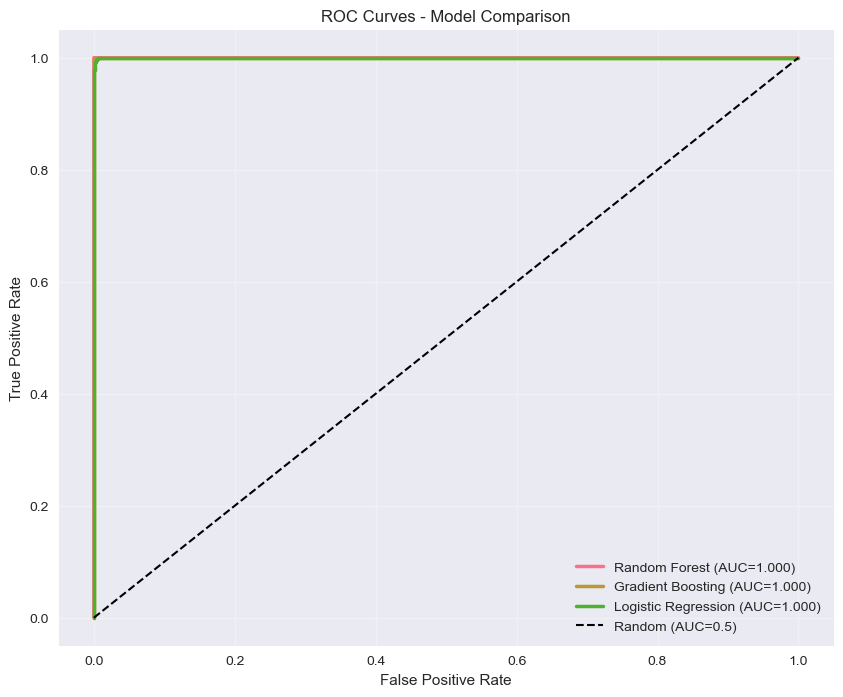

In [48]:
print("\nROC Curves...")

plt.figure(figsize=(10, 8))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_rf:.3f})', linewidth=2.5)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC={roc_auc_gb:.3f})', linewidth=2.5)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_lr:.3f})', linewidth=2.5)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(alpha=0.3)

import os
os.makedirs('results', exist_ok=True)
plt.savefig('results/roc_curves.png', dpi=300, bbox_inches='tight')
print("Kaydedildi: results/roc_curves.png")
plt.show()


Confusion Matrices...
Kaydedildi: results/confusion_matrices.png


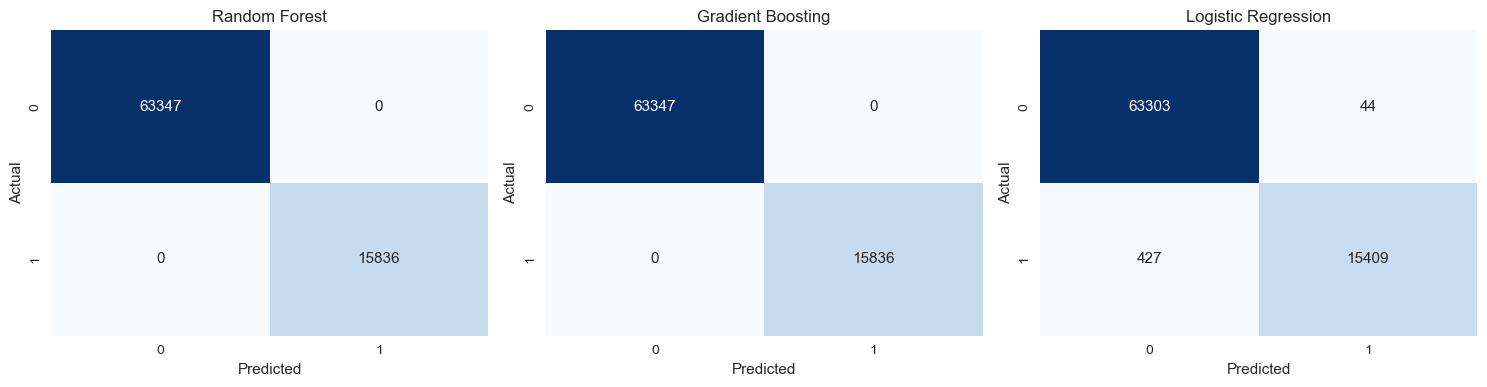


Feature Importance...
Kaydedildi: results/feature_importance.png


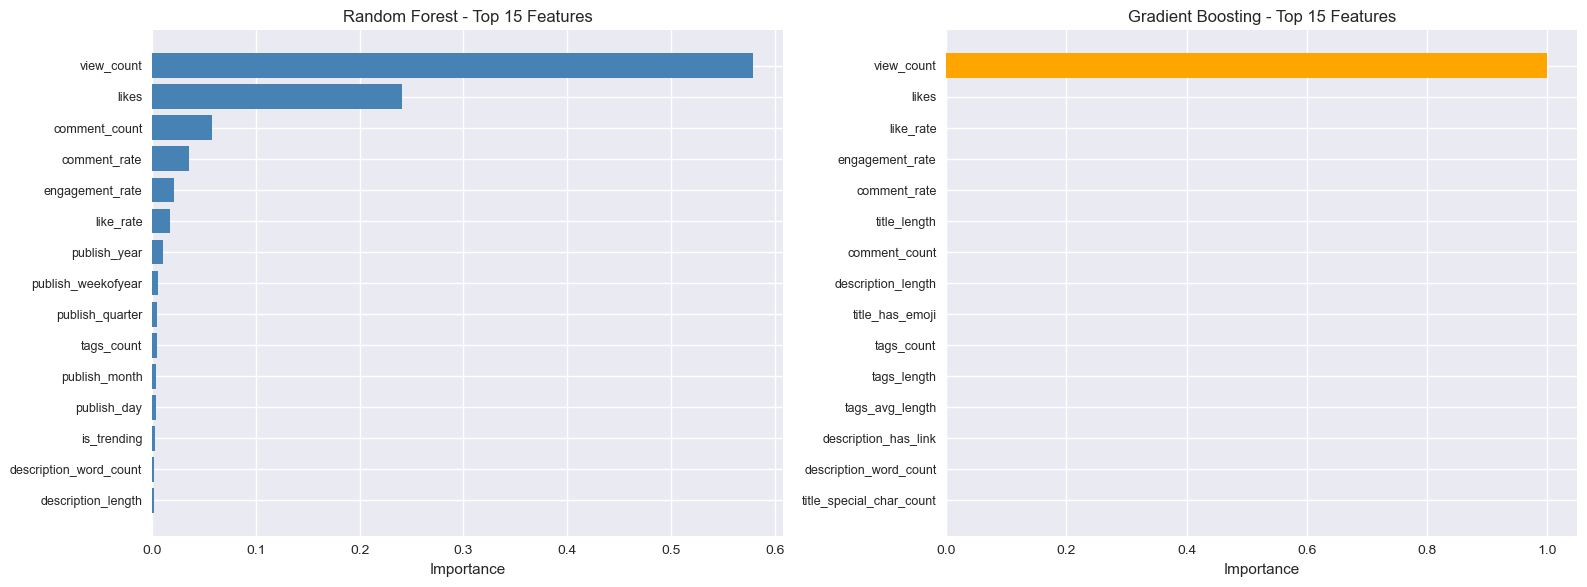

In [47]:
print("\nConfusion Matrices...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Random Forest')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)
axes[1].set_title('Gradient Boosting')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[2], cbar=False)
axes[2].set_title('Logistic Regression')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('results/confusion_matrices.png', dpi=300, bbox_inches='tight')
print("Kaydedildi: results/confusion_matrices.png")
plt.show()


# FEATURE IMPORTANCE
print("\nFeature Importance...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_rf = feature_importance_rf.head(15)
axes[0].barh(range(len(top_rf)), top_rf['importance'].values, color='steelblue')
axes[0].set_yticks(range(len(top_rf)))
axes[0].set_yticklabels(top_rf['feature'].values, fontsize=9)
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Top 15 Features')
axes[0].invert_yaxis()

top_gb = feature_importance_gb.head(15)
axes[1].barh(range(len(top_gb)), top_gb['importance'].values, color='orange')
axes[1].set_yticks(range(len(top_gb)))
axes[1].set_yticklabels(top_gb['feature'].values, fontsize=9)
axes[1].set_xlabel('Importance')
axes[1].set_title('Gradient Boosting - Top 15 Features')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('results/feature_importance.png', dpi=300, bbox_inches='tight')
print("Kaydedildi: results/feature_importance.png")
plt.show()
